In [1]:
from transformer_analysis import evaluate_transformer

/usr/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
from qiskit.transpiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
from qiskit.transpiler.passes.mapping import *
from qiskit import BasicAer
from qiskit.mapper import CouplingMap
from qiskit import IBMQ
from qiskit import QuantumRegister, QuantumCircuit

from math import pi

In [3]:
IBMQ.load_accounts()

In [4]:
backend = BasicAer.get_backend( 'qasm_simulator' )
backend_qx4 = IBMQ.get_backend( 'ibmqx2' )

pm_optimize = PassManager()
pm_optimize.append( CXCancellation()  )
pm_optimize.append( Optimize1qGates() )

pm_unroll = PassManager()
pm_unroll.append( Unroller( ['u3', 'cx'] ) )

In [5]:
couplingmap = CouplingMap([ [0,1], [0,2], [1,2], [3,2], [4,2], [3,4] ])

In [6]:
def simple_optimize ( circuit ):
    for i in range( 3 ):
        circuit = transpile( circuit, backend, pass_manager=pm_optimize )
    return circuit

def simple_unroll ( circuit ):
    return transpile( circuit, backend, pass_manager=pm_unroll )

In [7]:
def basic_compiler ( circuit ):
    circuit = simple_optimize( circuit )
    pm = PassManager()
    pm.append( BasicSwap( couplingmap ) )
    pm.append( CXDirection( couplingmap ) )
    circuit = transpile( circuit, backend, pass_manager=pm )
    circuit = simple_optimize( circuit )
    return circuit

In [8]:
def lookahead_compiler ( circuit ):
    circuit = simple_optimize( circuit )
    pm = PassManager()
    pm.append( LookaheadSwap( couplingmap ) )
    pm.append( CXDirection( couplingmap ) )
    circuit = transpile( circuit, backend, pass_manager=pm )
    circuit = simple_optimize( circuit )
    return circuit

In [9]:
def stochastic_compiler ( circuit ):
    circuit = simple_optimize( circuit )
    pm = PassManager()
    pm.append( StochasticSwap( couplingmap, seed=0 ) )
    pm.append( CXDirection( couplingmap ) )
    circuit = transpile( circuit, backend, pass_manager=pm )
    circuit = simple_optimize( circuit )
    return circuit

In [10]:
def no_transformation ( circuit ):
    return circuit

In [11]:
# Circuit

num_qubits = 5; # The number of qubits

q = QuantumRegister(num_qubits, 'q')
circuit = QuantumCircuit(q)

# Start Circuit
# Source: https://github.com/Qiskit/qiskit-terra/blob/master/examples/python/qft.py
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])

qft( circuit, q, num_qubits )

# End Circuit

circuit.draw( output='mpl', style = { 'usepiformat': True } )

<Figure size 1505x443.139 with 1 Axes>

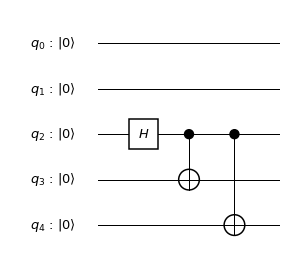

In [12]:
q = QuantumRegister( 5, 'q' )
circ = QuantumCircuit(q)

circ.h( q[2] )
circ.cx( q[2], q[3] ) 
circ.cx( q[2], q[4] )

circ.draw( output='mpl', style = { 'usepiformat': True } )

/usr/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/usr/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/usr/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/usr/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recom

0.0016799919386389936
0.0016799919386389936


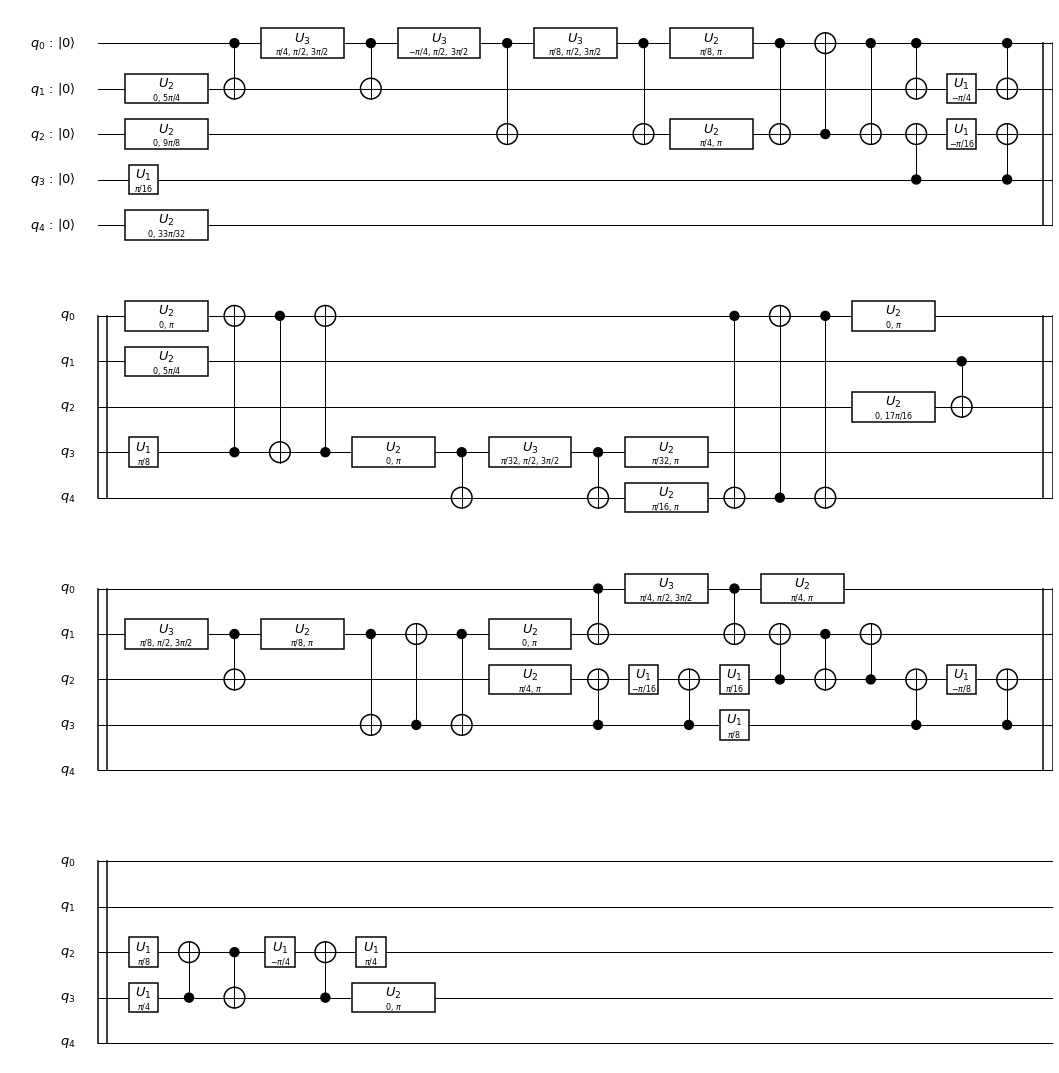

In [13]:
x = evaluate_transformer( stochastic_compiler, [circuit] )
print(x[0])
x[1].draw( output='mpl', style = { 'usepiformat': True } )

0.0619949905254833
0.0619949905254833


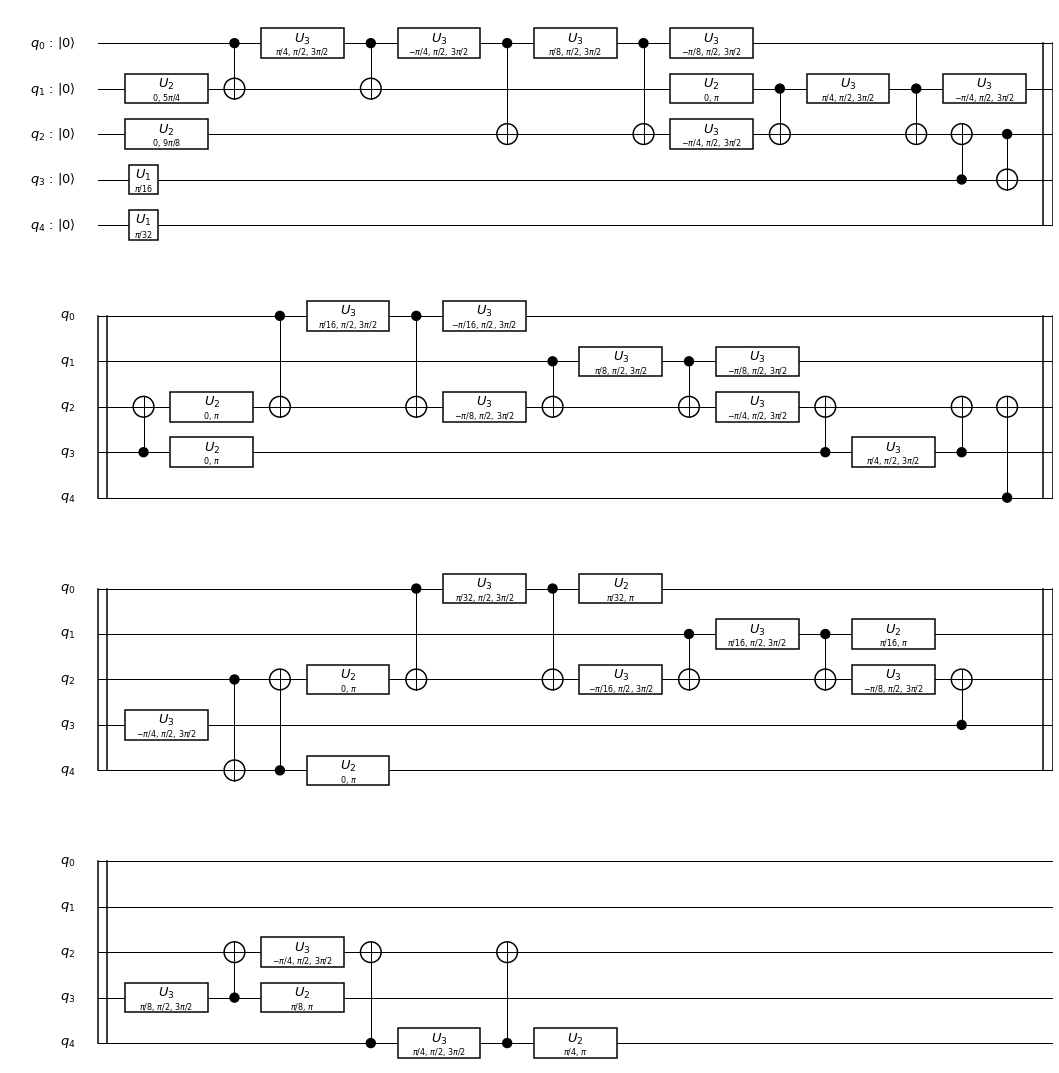

In [14]:
x = evaluate_transformer( lookahead_compiler, [circuit] )
print(x[0])
x[1].draw( output='mpl', style = { 'usepiformat': True } )

In [15]:
evaluate_transformer( basic_compiler, [circuit] )

0.24845385757408725


(0.24845385757408725,
 <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f1728f402b0>)

In [16]:
evaluate_transformer( no_transformation, [circuit] )

0.9929289590970198


(0.9929289590970198,
 <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f16de349ac8>)